In [21]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

Area de impoets

In [62]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.feature import local_binary_pattern


In [23]:
# Função para carregar imagens de uma pasta
def carregar_imagens_pasta(base_path, target_size=(224, 224)):
    imagens = []
    labels = []
    
    # Percorre cada classe (pastas de classe)
    for classe in os.listdir(base_path):
        classe_path = os.path.join(base_path, classe, 'images')  # Caminho da pasta images
        
        # Verifica se é uma pasta válida
        if os.path.isdir(classe_path):
            # Percorre cada imagem dentro da pasta de imagens
            for img_name in os.listdir(classe_path):
                img_path = os.path.join(classe_path, img_name)
                
                # Carrega a imagem usando cv2
                img = cv2.imread(img_path)
                
                # Verifica se a imagem foi carregada corretamente
                if img is not None:
                    # Redimensiona a imagem
                    img_resized = cv2.resize(img, target_size)
                    
                    # Normaliza a imagem (opcional: normalize entre [0, 1])
                    img_normalized = img_resized / 255.0
                    
                    # Adiciona a imagem e o label (nome da classe) à lista
                    imagens.append(img_normalized)
                    labels.append(classe)
    
    return np.array(imagens), np.array(labels)


In [37]:
def create_MLP_model(input_dim, output_dim, dense_layers):
    model = models.Sequential()
    
    # Redimensionar os dados de entrada
    model.add(layers.Reshape((input_dim,), input_shape=(input_dim, 1)))
    
    model.add(layers.Dense(dense_layers[0], activation='relu'))

    for neurons in dense_layers[1:]:
        model.add(layers.Dense(neurons, activation='relu'))

    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_CNN_model(input, num_classes):
    model = Sequential([
    # Camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=input),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada de flattening
    Flatten(),
    
    # Camada densa
    Dense(128, activation='relu'),
    
    # Camada de saída com softmax
    Dense(num_classes, activation='softmax')])

    # 3. Compilar o Modelo
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model


In [25]:
def coletor_Hu(imagem):
    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(imagem_cinza)
    saida = cv2.HuMoments(moments).flatten()
    return saida

def coletor_LBP(imagem, raio=1, pontos=8, metodo='uniform'):

    raio = 1  # Raio do círculo
    pontos = 8 * raio  # Número de pontos ao redor do círculo

    imagem = (imagem * 255).astype(np.uint8)
    # Converter para escala de cinza
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    # Calcular o LBP da imagem
    lbp = local_binary_pattern(imagem_cinza, pontos, raio, metodo).flatten()
    
    return lbp

def concatenar_inputs(Hu, LBP):
    return np.concatenate((Hu, LBP))

def cridaor_input_unico(imagem):
    hu_image = coletor_Hu(imagem)
    LBP = coletor_LBP(imagem)
    saida = concatenar_inputs(hu_image, LBP)
    return saida

def produtor_MLP_Base(Base_criator):
    saida_base = []
    for x in Base_criator:
        saida_base.append(cridaor_input_unico(x))
    return saida_base


In [26]:
def mostrar_exemplos(imagens, labels, classes, num_exemplos=3):
    # Configura a visualização
    fig, axes = plt.subplots(len(classes), num_exemplos, figsize=(15, 5 * len(classes)))
    
    for i, classe in enumerate(classes):
        # Filtra imagens da classe atual
        indices = np.where(labels == classe)[0]
        exemplos = np.random.choice(indices, num_exemplos, replace=False)
        
        for j, idx in enumerate(exemplos):
            img = imagens[idx]
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
        
        # Adiciona o título no centro da coluna da classe
        ax_title = axes[i, num_exemplos // 2]
        ax_title.set_title(f'{classe}', fontsize=12, fontweight='bold', ha='center', va='center')
        ax_title.axis('off')
    
    plt.tight_layout()
    plt.show()

In [27]:
# Carregar imagens de treino
train_path = 'Data/Train'
X_train, y_train = carregar_imagens_pasta(train_path)

# Carregar imagens de validação
val_path = 'Data/Val'
X_val, y_val = carregar_imagens_pasta(val_path)


In [28]:
# Visualizar a quantidade de imagens carregadas
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de validação: {len(X_val)}")
print(f"Total de classes: {set(y_val)}")

Total de imagens de treino: 4737
Total de imagens de validação: 512
Total de classes: {'Glioma', 'No Tumor', 'Meningioma', 'Pituitary'}


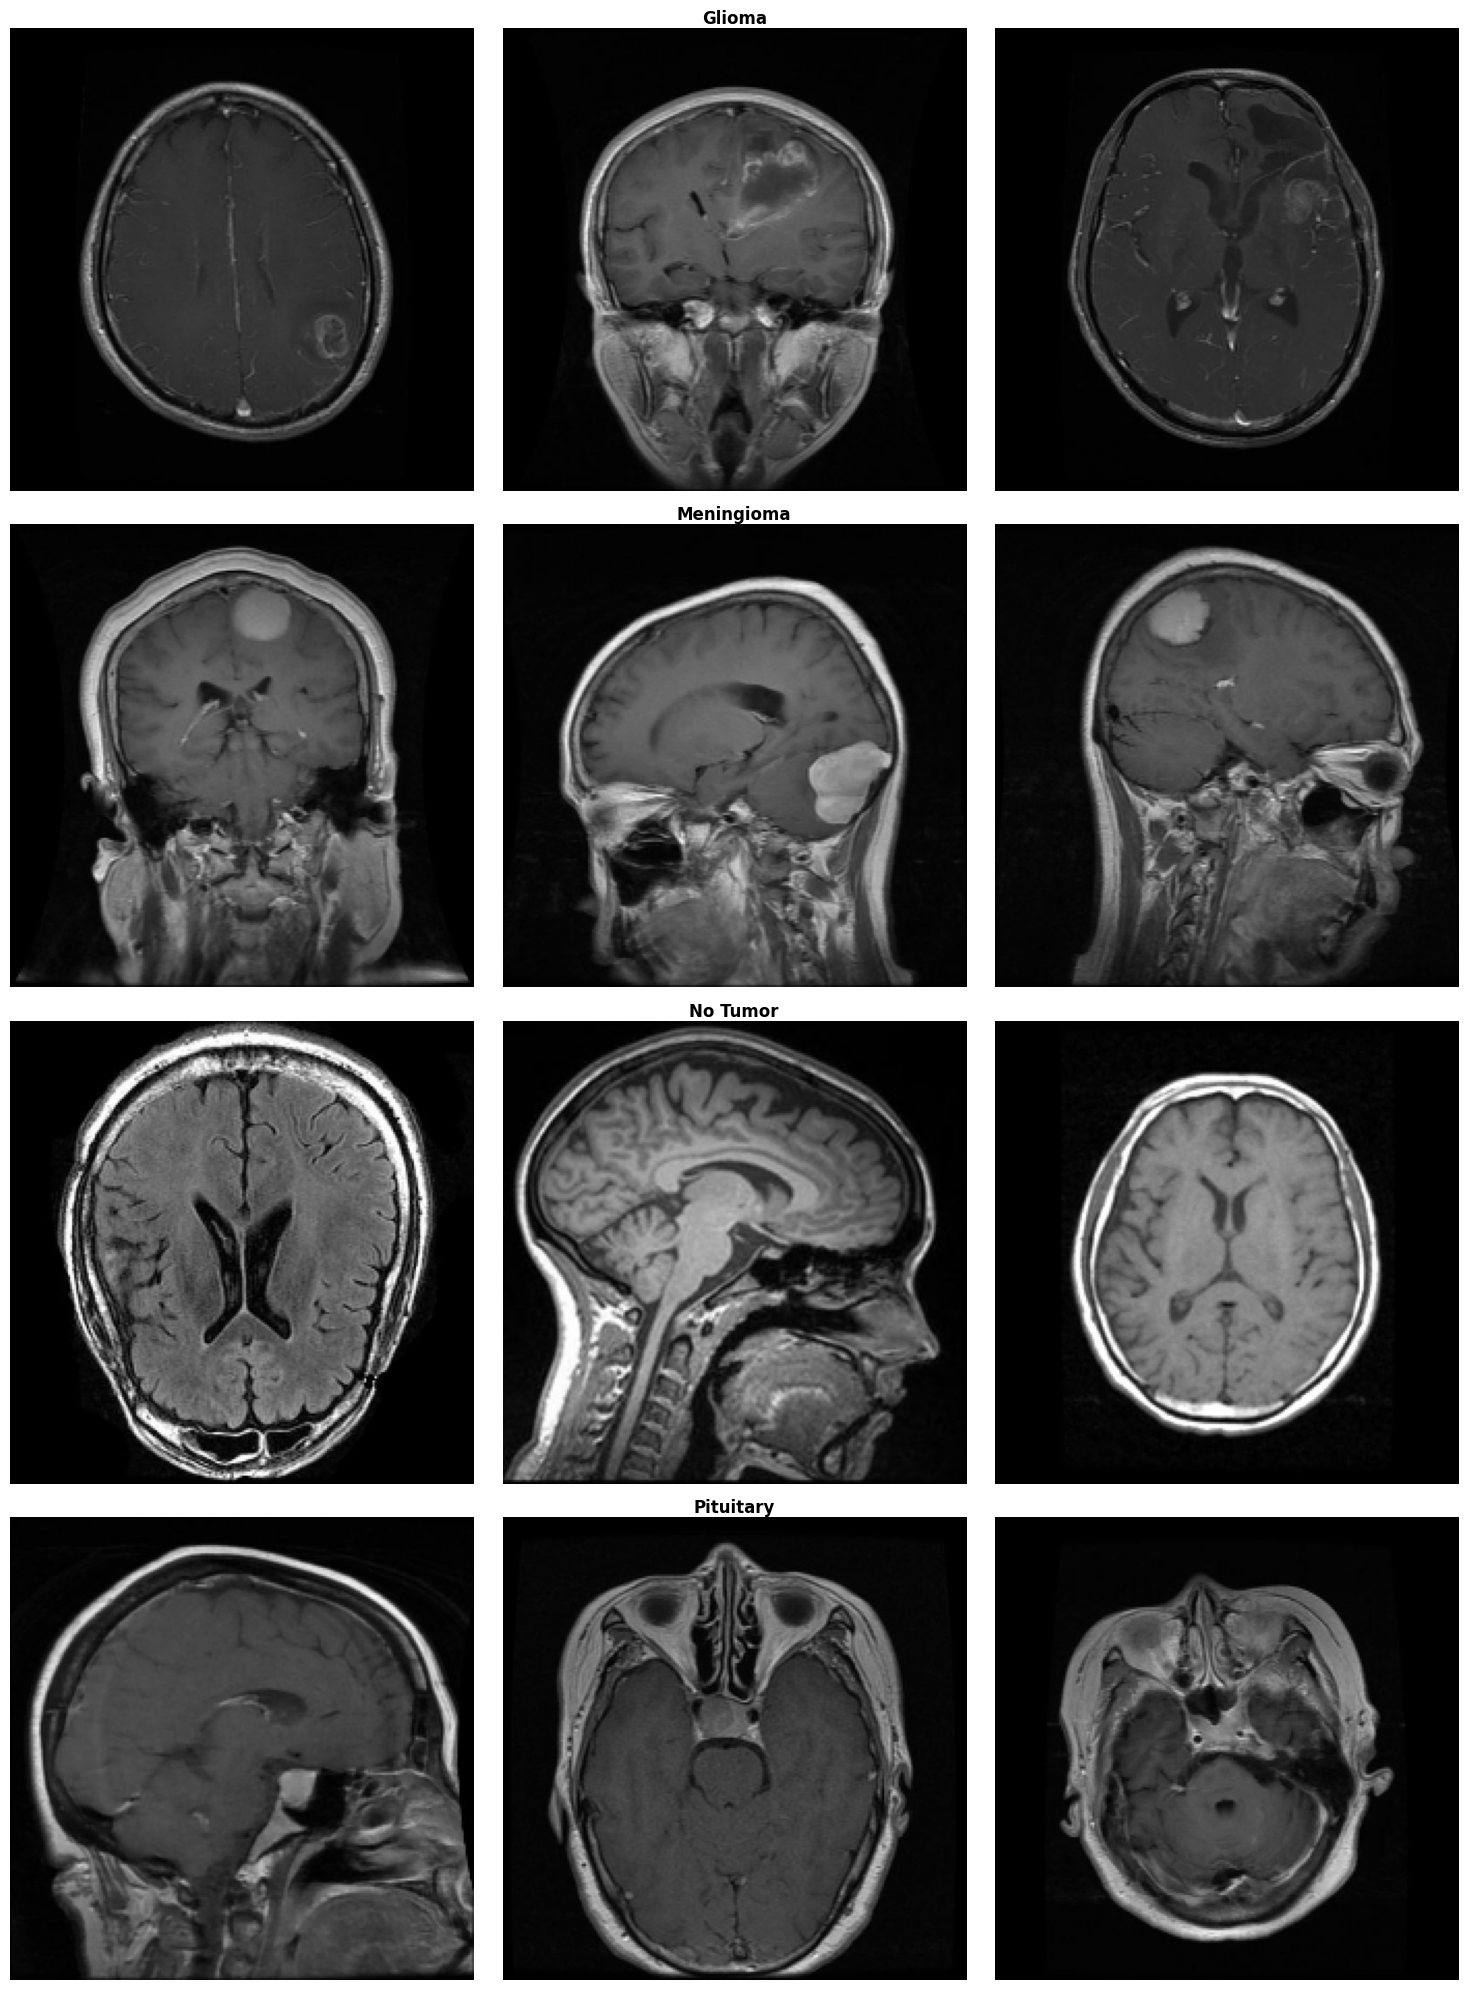

In [29]:
# Supondo que você já carregou as imagens e rótulos
# Classes devem ser as labels únicas presentes no seu dataset
classes = np.unique(y_train)
mostrar_exemplos(X_train, y_train, classes)


In [30]:
X_MLP_base_train = np.array(produtor_MLP_Base(X_train))
X_MLP_base_val = np.array(produtor_MLP_Base(X_val))

In [31]:
# Codificar os rótulos de classe em números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [38]:
# One-hot encoding dos rótulos
num_classes = len(np.unique(y_train_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

In [59]:
input_shape = X_train[0].shape
saida = num_classes

model_cnn = create_CNN_model(input_shape, saida)

c:\Users\vinic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [47]:
input = len(X_MLP_base_train[0])
saida = num_classes
dense_layers = [64, 32, 64]

model_mlp = create_MLP_model(input, saida, dense_layers)

c:\Users\vinic\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
history_mlp = model_mlp.fit(
    X_MLP_base_train, y_train_one_hot,
    epochs=20,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_MLP_base_val, y_val_one_hot)
)

val_loss, val_accuracy = model_mlp.evaluate(X_MLP_base_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3109 - loss: 19.4337 - val_accuracy: 0.1953 - val_loss: 13.8295
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4599 - loss: 6.5125 - val_accuracy: 0.3848 - val_loss: 13.2800
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5406 - loss: 4.6509 - val_accuracy: 0.3086 - val_loss: 5.9459
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6886 - loss: 1.4340 - val_accuracy: 0.5371 - val_loss: 3.6149
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7856 - loss: 0.8642 - val_accuracy: 0.6055 - val_loss: 1.1785
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9177 - loss: 0.2100 - val_accuracy: 0.7461 - val_loss: 0.6979
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9337 - loss: 0.1970 - val_accuracy: 0.4277 - val_loss: 7.9717
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7454 - loss: 1.3883 - val_a

In [61]:
history_cnn = model_cnn.fit(
    X_train, y_train_one_hot,
    epochs=20,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

val_loss, val_accuracy = model_cnn.evaluate(X_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 605ms/step - accuracy: 0.5616 - loss: 1.1230 - val_accuracy: 0.7539 - val_loss: 0.5706
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - accuracy: 0.8442 - loss: 0.3821 - val_accuracy: 0.8613 - val_loss: 0.3857
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 591ms/step - accuracy: 0.9386 - loss: 0.1755 - val_accuracy: 0.9219 - val_loss: 0.2331
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 622ms/step - accuracy: 0.9677 - loss: 0.0980 - val_accuracy: 0.8965 - val_loss: 0.3490
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 92s 614ms/step - accuracy: 0.9863 - loss: 0.0457 - val_accuracy: 0.8945 - val_loss: 0.3963
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 91s 610ms/step - accuracy: 0.9866 - loss: 0.0353 - val_accuracy: 0.9336 - val_loss: 0.2280
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 602ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9141 - val_loss: 0.3979
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 601ms/step - accuracy: 0.9966 - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


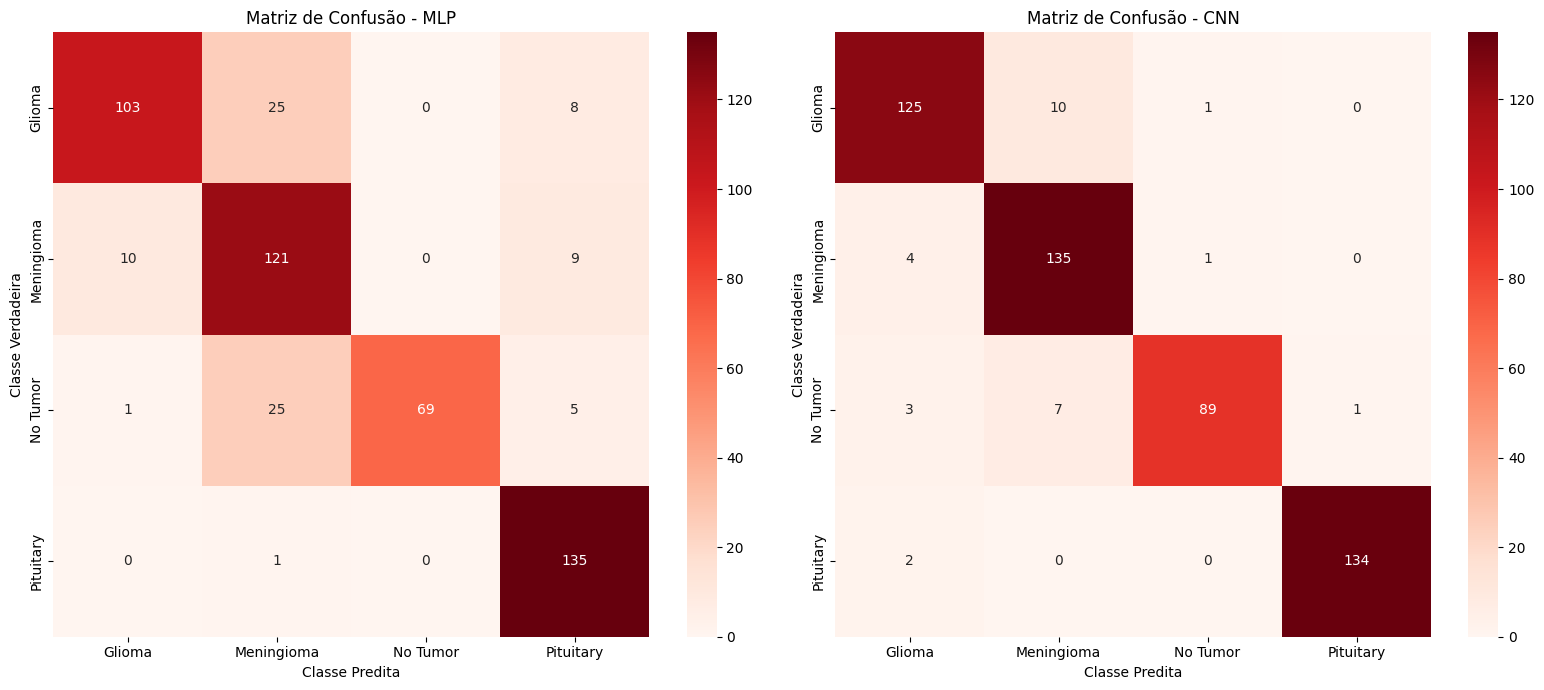

In [69]:
# 1. Fazer previsões usando o modelo MLP
y_pred_mlp = model_mlp.predict(X_MLP_base_val)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)

# 2. Fazer previsões usando o modelo CNN
y_pred_cnn = model_cnn.predict(X_val)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# 3. Converter os rótulos de validação em classes
y_true = np.argmax(y_val_one_hot, axis=1)

# 4. Calcular as matrizes de confusão
conf_matrix_mlp = confusion_matrix(y_true, y_pred_classes_mlp)
conf_matrix_cnn = confusion_matrix(y_true, y_pred_classes_cnn)

# 5. Plotar as duas matrizes de confusão lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Matriz de confusão do MLP
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Matriz de Confusão - MLP')
axes[0].set_xlabel('Classe Predita')
axes[0].set_ylabel('Classe Verdadeira')

# Matriz de confusão do CNN
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title('Matriz de Confusão - CNN')
axes[1].set_xlabel('Classe Predita')
axes[1].set_ylabel('Classe Verdadeira')

plt.tight_layout()
plt.show()

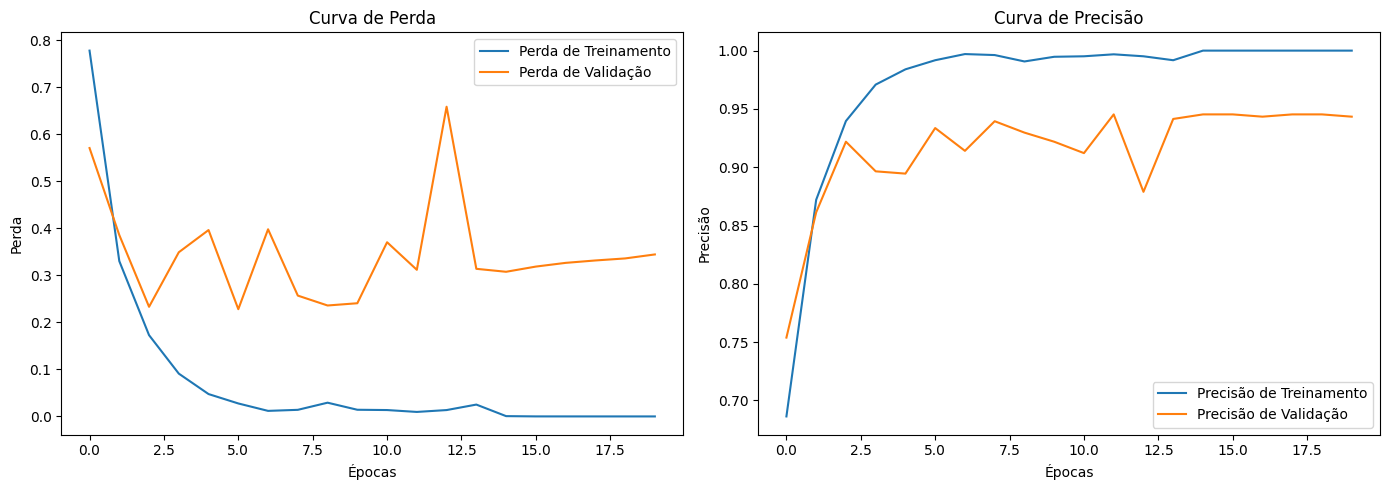

In [68]:
# 1. Plotar a curva de perda
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perda de Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# 2. Plotar a curva de precisão
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Precisão de Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisão de Validação')
plt.title('Curva de Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()


In [63]:
# Salvar o modelo MLP
model_mlp.save('modelo_mlp.h5')

# Salvar o modelo CNN
model_cnn.save('modelo_cnn.h5')

In [64]:
# Salvar o histórico de treinamento do MLP
with open('historico_treinamento_mlp.json', 'w') as f:
    json.dump(history_mlp.history, f)

# Salvar o histórico de treinamento do CNN
with open('historico_treinamento_cnn.json', 'w') as f:
    json.dump(history_cnn.history, f)


In [ ]:
# Carregar o histórico de treinamento do MLP
with open('historico_treinamento_mlp.json', 'r') as f:
    historico_mlp_carregado = json.load(f)

# Carregar o histórico de treinamento do CNN
with open('historico_treinamento_cnn.json', 'r') as f:
    historico_cnn_carregado = json.load(f)
